In [9]:
# tools
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Data Preparation


In [10]:
# Constants
DATA_DIR = "../dataset/embeddings/"
EMBEDDING_MODELS = os.listdir(DATA_DIR)
DATASETS = {
    model: [os.path.splitext(dataset)[0] for dataset in os.listdir(DATA_DIR + model)]
    for model in EMBEDDING_MODELS
}
print(DATASETS)
DATASETS_DIR = [
    "../models/classification/" + key + "/" + dataset + "/"
    for key, value in DATASETS.items()
    for dataset in value
]
print(DATASETS_DIR)

{'bioBERT': [], 'bioGPT': [], 'scBERT': ['scbert_embeddings'], 'scGPT': ['scgpt_aml_embeddings']}
['../models/classification/scBERT/scbert_embeddings/', '../models/classification/scGPT/scgpt_aml_embeddings/']


In [11]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score,
)


def EvaluateModel(y_test, y_pred, model_name):
    metrics = {
        "Accuracy": accuracy_score,
        "F1 Score": f1_score,
        "Precision": precision_score,
        "Recall": recall_score,
        "roc-auc": roc_auc_score,
    }
    eval_results = {"model": model_name}
    for metric, function in metrics.items():
        eval = function(y_test, y_pred)
        eval_results[metric] = eval
        print(metric, eval)
    return eval_results


def plotConfusionMatrix(y_test, y_pred, model_name, model_dir):
    # calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Death Prediction Confusion Matrix")
    plt.savefig(os.path.join(model_dir, f"{model_name}_confusion_matrix.png"))
    plt.show()
    plt.close()

In [12]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV


def trainClassificationModel(X, y, model_dir):
    classification_models = [
        (
            "SVM",
            SVC(random_state=42),
            {
                "C": [1e-3, 1e-2, 1e-1, 1, 10],
                "kernel": ["linear", "rbf"],
                "gamma": ["scale", "auto"],
            },
        ),
        (
            "RF",
            RandomForestClassifier(random_state=42, n_jobs=-1),
            {
                "n_estimators": [50, 100, 200],
                "max_depth": [None, 10, 20, 30],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
            },
        ),
        (
            "XGB",
            XGBClassifier(random_state=42, n_jobs=-1),
            {
                "n_estimators": [50, 100, 200],
                "max_depth": [3, 6, 9],
                "learning_rate": [0.01, 0.1, 0.2],
                "subsample": [0.8, 1.0],
                "colsample_bytree": [0.8, 1.0],
            },
        ),
        (
            "LGBM",
            LGBMClassifier(random_state=42, n_jobs=-1),
            {
                "n_estimators": [50, 100, 200],
                "max_depth": [3, 6, 9],
                "learning_rate": [0.01, 0.1, 0.2],
                "subsample": [0.8, 1.0],
                "colsample_bytree": [0.8, 1.0],
            },
        ),
        (
            "KNN",
            KNeighborsClassifier(n_jobs=-1),
            {
                "n_neighbors": [3, 5, 7],
                "weights": ["uniform", "distance"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
            },
        ),
        (
            "ADA",
            AdaBoostClassifier(random_state=42),
            {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1, 1.0],
                "algorithm": ["SAMME", "SAMME.R"],
            },
        ),
    ]

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1121
    )
    results = []

    for name, model, param_grid in classification_models:
        print(f"Starting training for {name} with GridSearchCV...")
        grid_search = GridSearchCV(
            model, param_grid, cv=5, scoring="accuracy", n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        results.append(EvaluateModel(y_test, y_pred, name))
        plotConfusionMatrix(y_test, y_pred, name, model_dir)
        model_path = os.path.join(model_dir, name + ".pkl")
        with open(model_path, "wb") as f:
            pickle.dump(best_model, f)
    results = pd.DataFrame(results)
    results.to_csv(os.path.join(model_dir, "results.csv"), index=False)
    print("classification_models and results saved in {}".format(model_dir))

shape:  (170, 770)
columns:  Index(['Survival', 'Death', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '758', '759', '760', '761', '762', '763', '764', '765', '766', '767'],
      dtype='object', length=770)
features:  (159, 768)
target death:  (159,)
Starting training for SVM with GridSearchCV...
Accuracy 0.6875
F1 Score 0.8148148148148148
Precision 0.6875
Recall 1.0
roc-auc 0.5


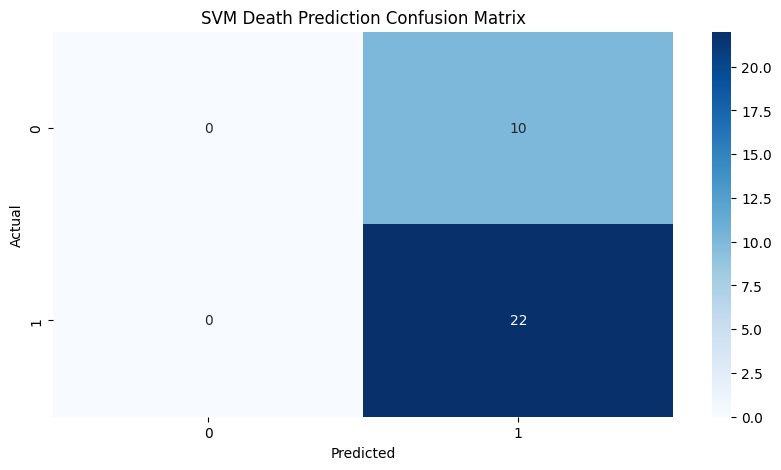

Starting training for RF with GridSearchCV...
Accuracy 0.65625
F1 Score 0.7755102040816326
Precision 0.7037037037037037
Recall 0.8636363636363636
roc-auc 0.5318181818181817


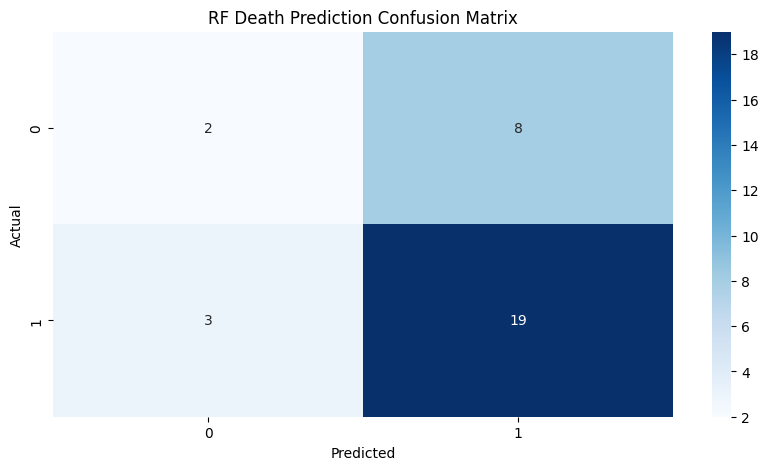

Starting training for XGB with GridSearchCV...
Accuracy 0.71875
F1 Score 0.8163265306122449
Precision 0.7407407407407407
Recall 0.9090909090909091
roc-auc 0.6045454545454546


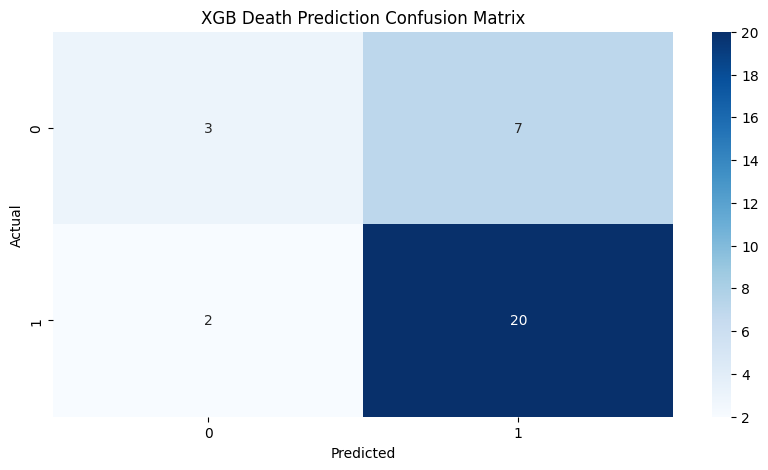

Starting training for LGBM with GridSearchCV...
[LightGBM] [Info] Number of positive: 81, number of negative: 46
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33792
[LightGBM] [Info] Number of data points in the train set: 127, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.637795 -> initscore=0.565808
[LightGBM] [Info] Start training from score 0.565808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

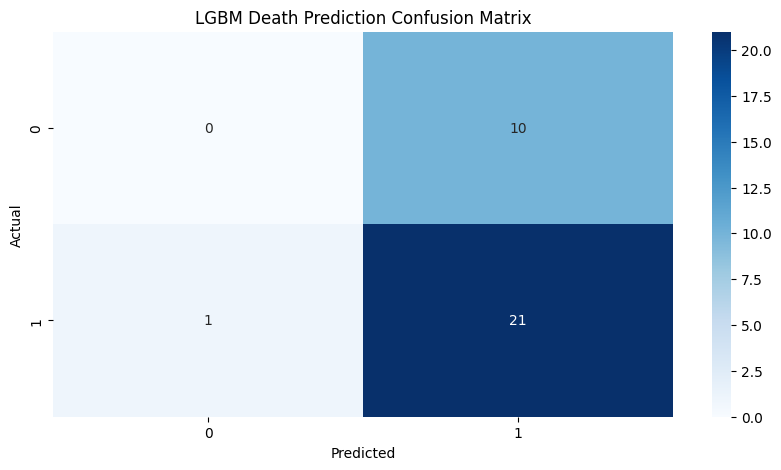

Starting training for KNN with GridSearchCV...
Accuracy 0.6875
F1 Score 0.7916666666666666
Precision 0.7307692307692307
Recall 0.8636363636363636
roc-auc 0.5818181818181818


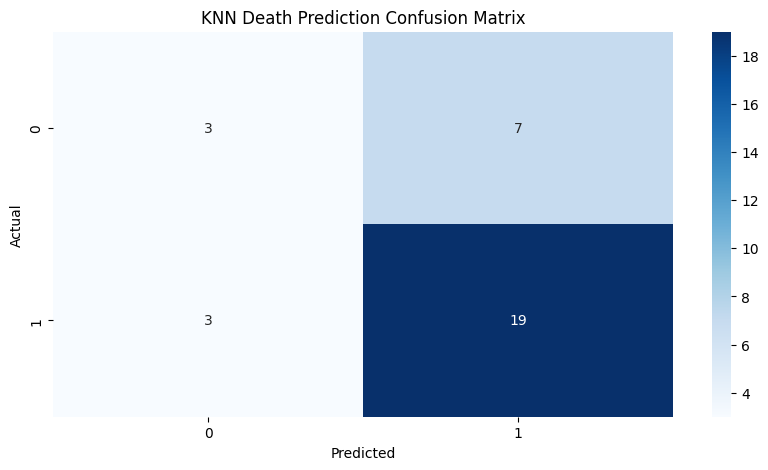

Starting training for ADA with GridSearchCV...


c:\Users\mahdj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy 0.59375
F1 Score 0.7111111111111111
Precision 0.6956521739130435
Recall 0.7272727272727273
roc-auc 0.5136363636363637


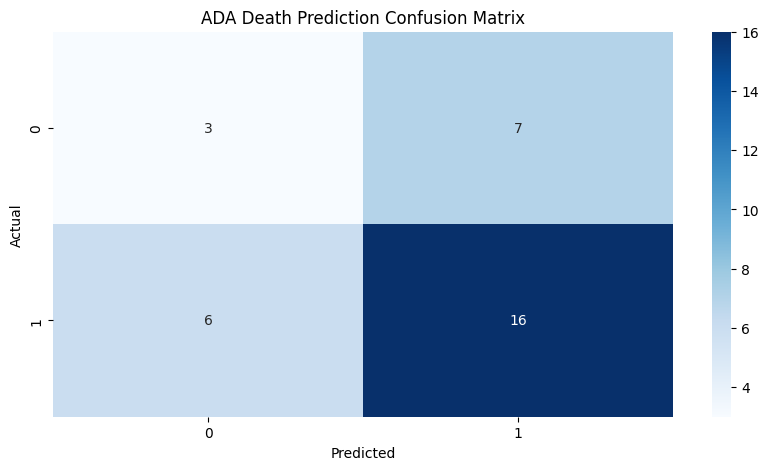

classification_models and results saved in ../models/classification/scBERT/scbert_embeddings/Death/
shape:  (170, 514)
columns:  Index(['Survival', 'Death', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=514)
features:  (159, 512)
target death:  (159,)
Starting training for SVM with GridSearchCV...
Accuracy 0.625
F1 Score 0.7692307692307693
Precision 0.625
Recall 1.0
roc-auc 0.5


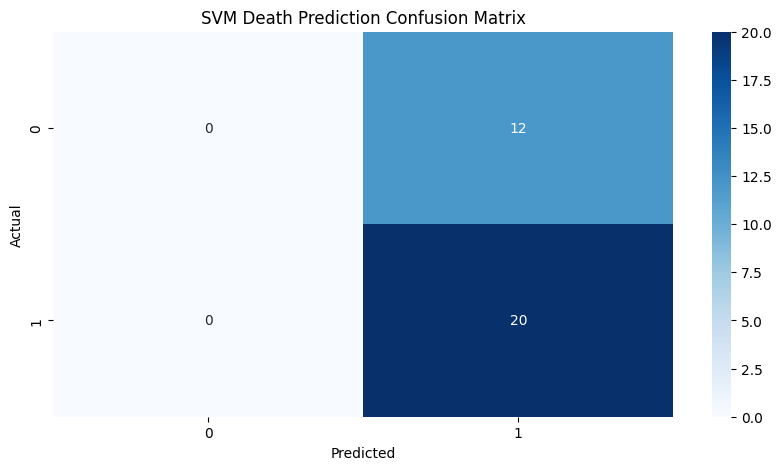

Starting training for RF with GridSearchCV...
Accuracy 0.625
F1 Score 0.7692307692307693
Precision 0.625
Recall 1.0
roc-auc 0.5


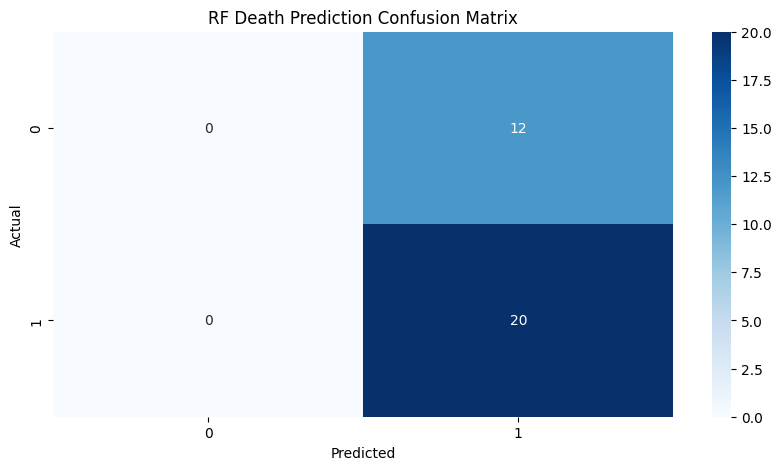

Starting training for XGB with GridSearchCV...
Accuracy 0.625
F1 Score 0.7692307692307693
Precision 0.625
Recall 1.0
roc-auc 0.5


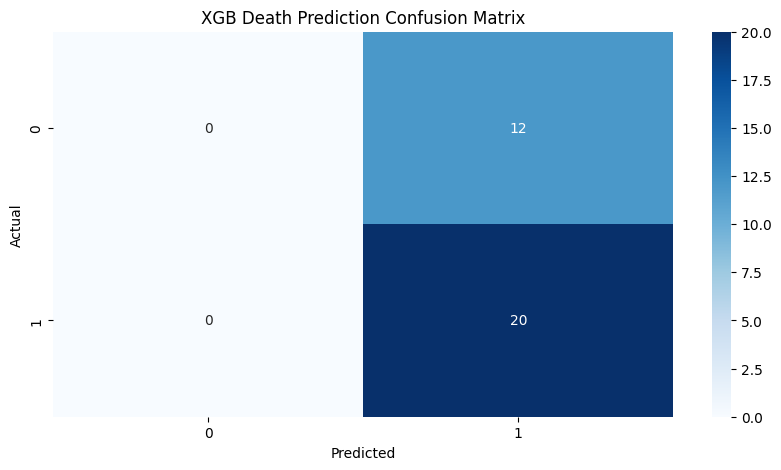

Starting training for LGBM with GridSearchCV...
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 83, number of negative: 44
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 127, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.653543 -> initscore=0.634651
[LightGBM] [Info] Start training from score 0.634651
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


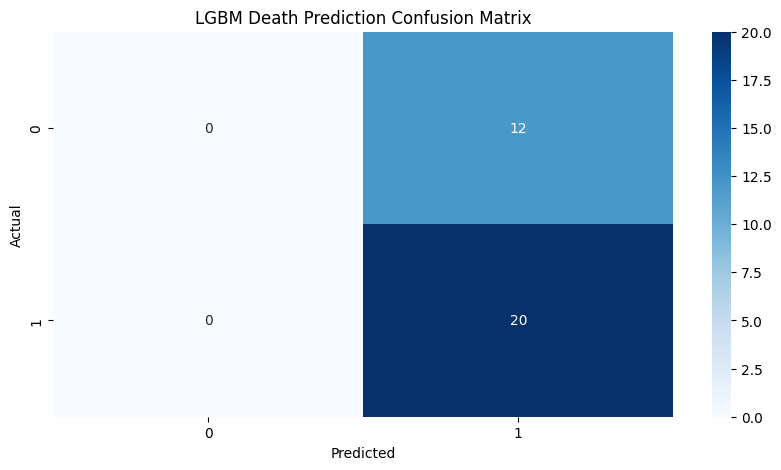

Starting training for KNN with GridSearchCV...
Accuracy 0.625
F1 Score 0.7692307692307693
Precision 0.625
Recall 1.0
roc-auc 0.5


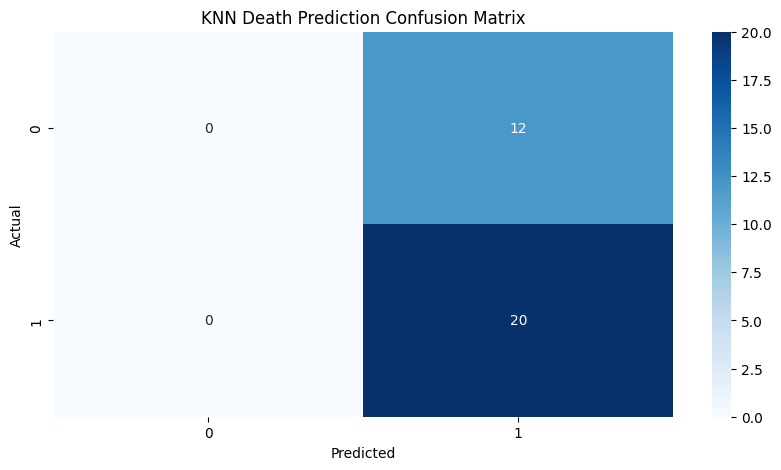

Starting training for ADA with GridSearchCV...
Accuracy 0.625
F1 Score 0.7692307692307693
Precision 0.625
Recall 1.0
roc-auc 0.5


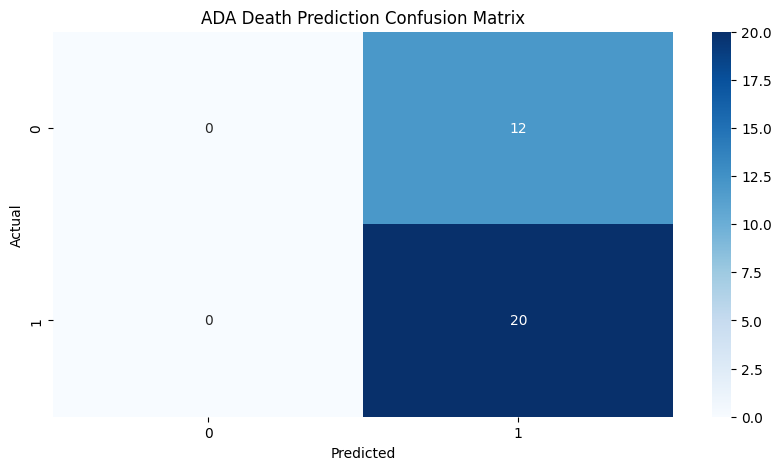

classification_models and results saved in ../models/classification/scGPT/scgpt_aml_embeddings/Death/


In [13]:
# train models

for key, value in DATASETS.items():
    for dataset in value:
        models_output_dir = "../models/classification/" + key + "/" + dataset + "/"
        dataset_dir = os.path.join(DATA_DIR, key, dataset)
        # load data
        df = pd.read_csv(dataset_dir + ".csv")
        print("shape: ", df.shape)
        print("columns: ", df.columns)
        #  check for missing values
        df.isnull().sum()
        df.dropna(inplace=True)
        df.isnull().sum()
        # split the data into features and target

        X = df.drop(["Death", "Survival"], axis=1)
        print("features: ", X.shape)
        y_death = df["Death"]
        print("target death: ", y_death.shape)
        DEATH_MODEL_DIR = models_output_dir + "Death/"
        # training models
        if not os.path.exists(DEATH_MODEL_DIR):
            os.makedirs(DEATH_MODEL_DIR)
        trainClassificationModel(X, y_death, model_dir=DEATH_MODEL_DIR)